<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/adding_gender/2_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# colab
from google.colab import drive

# data
import pandas as pd

# math
import numpy as np

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

## PEP8 code standard

In [2]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers

def reload_modules(modules):
    for module in modules:
        importlib.reload(module)

reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from sklearn_transformers import OutlierCleaner

# Set up paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 6
MODELS_TRIAL = 4
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_6 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_4 already exists


# Download the data

In [53]:
df_train = pd.read_csv(manager.train_path, index_col='Unnamed: 0')
df_test = pd.read_csv(manager.test_path, index_col='Unnamed: 0')

In [54]:
df_train.columns, df_test.columns

(Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
        'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'Name', 'Transported', 'gender'],
       dtype='object'),
 Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
        'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'Name', 'gender'],
       dtype='object'))

# Checking NAN

In [ ]:
from sklearn_utils import nan_statistics


_ = nan_statistics(df_train)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855


In [ ]:
_ = nan_statistics(df_test)

Col -- Nan percentage
FoodCourt 2.4783726911386488
Spa 2.3614683189151275
Cabin 2.338087444470423
ShoppingMall 2.2913256955810146
Name 2.197802197802198
CryoSleep 2.1744213233574934
VIP 2.1744213233574934
Destination 2.1510404489127897
Age 2.127659574468085
HomePlanet 2.034136076689268
RoomService 1.917231704465747
VRDeck 1.8704699555763384


# Check infinity values

In [ ]:
from sklearn_utils import inf_statistics


inf_statistics(df_train)

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [ ]:
inf_statistics(df_test)

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [ ]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

# Engineer new features

## Did a person buy any luxury service?

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin


class BoughtLuxuryItems(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['BoughtAnyLuxury'] = \
            (transformed_df['ShoppingMall'] > 0.0) \
            | (transformed_df['FoodCourt'] > 0.0) \
            | (transformed_df['VRDeck'] > 0.0) \
            | (transformed_df['Spa'] > 0.0) \
            | (transformed_df['RoomService'] > 0.0)
        return transformed_df


pep8(_ih)

In [56]:
bought_luxury_items = BoughtLuxuryItems()

df_train = bought_luxury_items.fit_transform(df_train)
df_test = bought_luxury_items.transform(df_test)

## DeckNum, DeckSide, Deck

In [57]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckNumAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_deck_num(self, deck):
        if type(deck) is str:
            split_items = deck.split('/')
            return int(split_items[1])
        else:
            return 0

    def transform(self, X, y=None):
        df_transformed = X.copy()
        df_transformed['DeckNum'] = df_transformed['Cabin'] \
            .map(self.get_deck_num)
        return df_transformed


pep8(_ih)

In [58]:
deck_num_adder = DeckNumAdder()
df_train = deck_num_adder.fit_transform(df_train)
df_test = deck_num_adder.transform(df_test)

In [59]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckSideAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def add_deck_side(self, val):
        if type(val) is str:
            return val.split('/')[2]
        else:
            return 'NOT ASSIGNED'

    def transform(self, X, y=None):
        df_transformed = X.copy()
        df_transformed['DeckSide'] = df_transformed['Cabin'].map(
            self.add_deck_side
        )

        del X
        return df_transformed


pep8(_ih)

In [60]:
deck_side_adder = DeckSideAdder()

df_train = deck_side_adder.fit_transform(df_train)
df_test = deck_side_adder.transform(df_test)

In [61]:
from sklearn.base import TransformerMixin, BaseEstimator


class DeckAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def add_deck(self, val):
        if type(val) is str:
            return val.split('/')[0]
        else:
            return 'NOT ASSIGNED'

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['Deck'] = transformed_df['Cabin'].map(
            self.add_deck
        )
        del X
        return transformed_df


pep8(_ih)

In [62]:
deck_adder = DeckAdder()
df_train = deck_adder.fit_transform(df_train)
df_test = deck_adder.transform(df_test)

## PassengerGroup, PassengerPosition, SingleInGroup, GroupSize



In [63]:
from sklearn.base import TransformerMixin, BaseEstimator


class PassengerGroupAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_passenger_group(self, val):
        if val is not np.nan:
            return int(val.split('_')[0])
        else:
            return val

    def transform(self, X, y=None):
        transformed_df = X.copy()
        transformed_df['PassengerGroup'] = \
            X['PassengerId'].map(self.get_passenger_group)
        del X
        return transformed_df


pep8(_ih)

In [64]:
group_adder = PassengerGroupAdder()
df_train = group_adder.fit_transform(df_train)
df_test = group_adder.transform(df_test)

In [65]:
from sklearn.base import TransformerMixin, BaseEstimator


class PassengerPositionAdder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def get_position(self, val):
        return int(val.split('_')[1])
    
    def transform(self, X, y=None):
        # df_transformed = X.copy()
        # del X
        X['PassengerGroupPosition'] = \
            X['PassengerId'].map(self.get_position)
        return X

In [66]:
position_adder = PassengerPositionAdder()
df_train = position_adder.fit_transform(df_train)
df_test = position_adder.transform(df_test)

In [67]:
from sklearn.base import TransformerMixin, BaseEstimator


class GroupSizeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.value_counts = None

    def fit(self, X, y=None):
        self.value_counts = X['PassengerGroup'].value_counts()
        return self

    def get_group_size(self, val):
        return self.value_counts.loc[val]

    def transform(self, X, y=None):
        X['GroupSize'] = \
            X['PassengerGroup'].map(self.get_group_size)
        X['AloneInGroup'] = X['GroupSize'] == 1
        return X
    

In [68]:
adder = GroupSizeAdder()
df_train = adder.fit_transform(df_train)

# Fit transform on test, because
# contains group numbers, not present in df_train
df_test = adder.fit_transform(df_test)

# Clean outliers

In [69]:
from sklearn_transformers import OutlierCleaner


cleaner = OutlierCleaner(
    ['VRDeck', 'Spa', 'RoomService', 'FoodCourt', 'ShoppingMall'],
    lower_quantile_=0.05,
    upper_quantile_=0.95
)

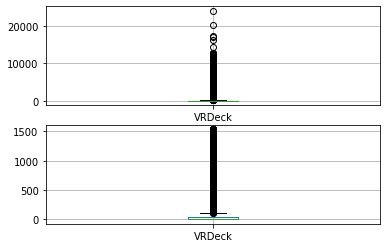

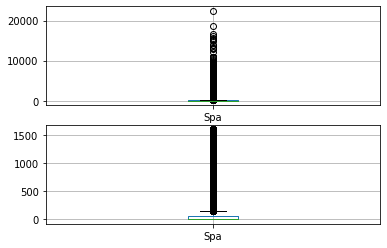

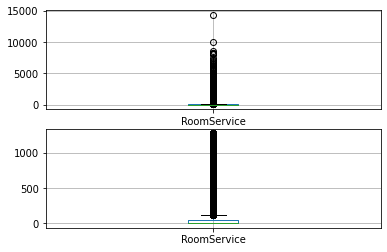

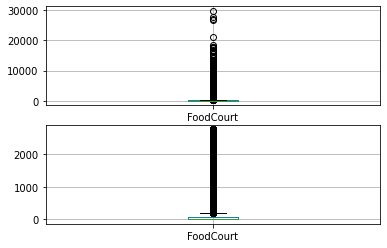

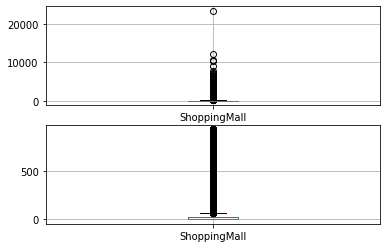

In [70]:
columns = ['VRDeck', 'Spa', 'RoomService', 'FoodCourt', 'ShoppingMall']

cleaner = OutlierCleaner(
    columns,
    0.05,
    0.95
)
df_result = cleaner.fit_transform(df_train)

import matplotlib.pyplot as plt
for column in columns:
    fig, ax = plt.subplots(2, 1)
    df_train.boxplot([column], ax=ax[0])
    df_result.boxplot([column], ax=ax[1])

In [71]:
df_train = cleaner.fit_transform(df_train)
df_test = cleaner.transform(df_test)

# Reduce number precision

In [ ]:
def reduce_precision(
    df_,
    original_dtypes_=['float64'],
    transcription_dict_={
        'float64': 'float32',
        'int64': 'int32'
    }
):
    '''
    For every column, that has a dtype in original_dtypes
    list --> it changes the original dtype, according to
    the transcription_dict_
    '''
    for numeric_type in original_dtypes_:
        mask = np.isin(df_.dtypes, [numeric_type])
        df_.loc[:, mask] = \
            df_.loc[:, mask].astype(transcription_dict_[numeric_type])
    return df_

In [ ]:
df_train = reduce_precision(df_train)

In [ ]:
df_test = reduce_precision(df_test)

In [ ]:
common_columns = set(df_train.columns).intersection(
    df_test.columns
)

assert (df_train.loc[:, common_columns].dtypes == \
        df_test.loc[:, common_columns].dtypes).all()

# Removing NAN / INF columns

- No columns with high content of NAN / INF values encountered

# Preparing processing pipelines

In [72]:
luxury_columns = [
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck'
]

luxury_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median'))
    ]
)

In [73]:
name_columns = [
    'Name'
]

name_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(name_columns))
    ]
)

In [74]:
age_columns = [
    'Age'
]

age_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('standardize', StandardScaler())
    ]
)

In [75]:
home_planet_columns = [
    'HomePlanet'
]

home_planet_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(missing_values=np.nan, strategy='constant')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [76]:
destination_columns = [
    'Destination'
]

destination_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(strategy='median')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [77]:
passenger_id_columns = [
    'PassengerId'
]

passenger_id_pipeline = Pipeline(
    [
        # ('impute', SimpleImputer(strategy='median')),
        ('drop', ColumnDropper(passenger_id_columns))
    ]
)

In [78]:
cabin_columns = [
    'Cabin'
]

cabin_pipeline = Pipeline(
    [
        ('drop', ColumnDropper(cabin_columns))
    ]
)

In [79]:
# Consider here also one-hot encoding, substituting
# NAN values as "Missing"

cryo_sleep_columns = [
    'CryoSleep'
]

cryo_sleep_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median'))
    ]
)

In [80]:
vip_columns = [
    'VIP'
]

vip_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median'))
    ]
)

In [81]:
bought_any_luxury_columns = [
    'BoughtAnyLuxury'
]

bought_any_luxury_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
    ]
)

In [82]:
from sklearn.preprocessing import OrdinalEncoder


deck_columns = [
    'Deck'
]

deck_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
        (
            'encode',
            OrdinalEncoder(
                categories=[
                    [
                        'NOT ASSIGNED',
                        'A',
                        'B',
                        'C',
                        'D',
                        'E',
                        'F',
                        'G',
                        'T'
                    ]
                ]
            )
        )
    ]
)

In [83]:
deck_num_columns = [
    'DeckNum'
]

deck_num_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant'))
    ]
)

In [84]:
deck_size_columns = [
    'DeckSide'
]

deck_side_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [85]:
alone_columns = ['AloneInGroup']
alone_pipeline = Pipeline(
    [('impute', SimpleImputer(strategy='median'))]
)

In [86]:
group_position_columns = ['PassengerGroupPosition']
group_position_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [87]:
group_size_columns = ['GroupSize']
group_size_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [88]:
passenger_group_columns = ['PassengerGroup']
passenger_group_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)

In [89]:
gender_columns = ['gender']
gender_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value=0.0))
    ]
)

In [90]:
# all_columns = set()
all_columns = set(
    [
        *luxury_columns,
        *name_columns,
        *age_columns,
        *home_planet_columns,
        *destination_columns,
        *passenger_id_columns,
        *cabin_columns,
        *vip_columns,
        *cryo_sleep_columns,
        *bought_any_luxury_columns,
        *deck_columns,
        *deck_num_columns,
        *deck_size_columns,
     
        *alone_columns,
        *group_position_columns,
        *group_size_columns,
        *passenger_group_columns,
        *gender_columns

    ]
)

# print(df_train.columns)
assert (set(df_train.columns) - all_columns) == {'Transported'}, \
    print(set(df_train.columns) - all_columns)

In [92]:
from sklearn_transformers import ColumnDropper


preprocessor = ColumnTransformer(
    [
        ('luxury', luxury_pipeline, luxury_columns),
        ('drop', name_pipeline, name_columns),
        ('age', age_pipeline, age_columns),
        ('home_planet', home_planet_pipeline, home_planet_columns),
        ('destination', destination_pipeline, destination_columns),
        ('passenger_id', passenger_id_pipeline, passenger_id_columns),
        ('vip', vip_pipeline, vip_columns),
        ('cryo_sleep', cryo_sleep_pipeline, cryo_sleep_columns),
        ('cabin', cabin_pipeline, cabin_columns),
        
        ('bought_any_luxury', bought_any_luxury_pipeline, bought_any_luxury_columns),
        ('deck', deck_pipeline, deck_columns),
        ('deck_num', deck_num_pipeline, deck_num_columns),
        ('deck_side', deck_side_pipeline, deck_size_columns),
        
        ('alone_in_group', alone_pipeline, alone_columns),
        ('passenger_group_position', group_position_pipeline, group_position_columns),
        ('group_size', group_size_pipeline, group_size_columns),
        ('passenger_group', passenger_group_pipeline, passenger_group_columns),
        ('gender', gender_pipeline, gender_columns)
    ],
    remainder='passthrough'
)

# Splitting the training data

## Split the data

In [93]:
from sklearn.model_selection import train_test_split

TRAIN_VAL_PERCENTAGE = 0.8
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAIN_VAL_PERCENTAGE,
    random_state=RANDOM_STATE,
    stratify=df_train['Transported']
)

df_trainval.shape, df_test_sample.shape

((6954, 23), (1739, 23))

## Check class balance and feature distribution after splitting

In [94]:
print(df_trainval.Transported.value_counts())
print(df_test_sample.Transported.value_counts())

True     3502
False    3452
Name: Transported, dtype: int64
True     876
False    863
Name: Transported, dtype: int64


Visualizing datasets distributions


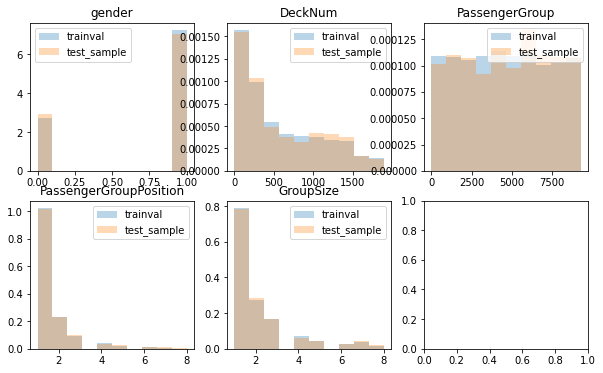

In [95]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    dataframes_dict_={
        'trainval': df_trainval,
        'test_sample': df_test_sample
    },
    columns_=df_trainval.columns[np.isin(df_trainval.dtypes, ['float32', 'int', ''])]
)

# Process data

In [96]:
df_trainval_processed = preprocessor.fit_transform(
    df_trainval
)

col_n = -1
assert (df_trainval_processed[:, col_n] == df_trainval['Transported']).all()

In [97]:
df_test_sample_processed = preprocessor.transform(
    df_test_sample
)
assert (df_test_sample_processed[:, -1] == df_test_sample['Transported']).all()

In [98]:
df_test['Transported'] = np.zeros(len(df_test))
df_test_processed = preprocessor.transform(df_test)

# removing fake "Transported" column
df_test_processed = df_test_processed[:, :-1]

In [99]:
assert (df_trainval_processed.dtype == 'float64') \
    & (df_test_sample_processed.dtype == 'float64') \
    & (df_test_processed.dtype == 'float64')

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

PERCENTILE = 80

feature_selector = SelectPercentile(
    score_func=f_classif,
    percentile=80
)
feature_selector.fit(
    df_trainval_processed[:, :-1],
    df_trainval_processed[:, -1]
)

SelectPercentile(percentile=80)

<BarContainer object of 26 artists>

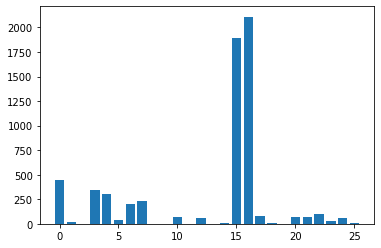

In [ ]:
plt.bar(
    list(range(len(feature_selector.scores_))),
    feature_selector.scores_,
)

In [ ]:
X_trainval_processed = feature_selector.fit_transform(
    df_trainval_processed[:, :-1], df_trainval_processed[:, -1])

X_test_sample_processed = feature_selector.transform(
    df_test_sample_processed[:, :-1]
)

X_test_processed = feature_selector.transform(
    df_test_processed
)

In [ ]:
df_trainval_processed = np.hstack(
    [
        X_trainval_processed,
        df_trainval_processed[:, -1].reshape(X_trainval_processed.shape[0], 1)
    ]
)

assert (df_trainval_processed[:, -1] == df_trainval.Transported).all()

In [ ]:
df_test_sample_processed = np.hstack(
    [
        X_test_sample_processed,
        df_test_sample_processed[:, -1].reshape(X_test_sample_processed.shape[0], 1)
    ]
)

assert (df_test_sample_processed[:, -1] == df_test_sample.Transported).all()

In [ ]:
df_test_processed = X_test_processed

# Save the data

In [104]:
df_trainval_processed.shape[1]

28

In [103]:
assert df_trainval_processed.shape[1] \
    == df_test_sample_processed.shape[1] \
    == df_test_processed.shape[1] + 1

manager.save_to_csv(
    df_trainval_processed,
    manager.data_trial_path,
    'trainval_processed.csv'
)

manager.save_to_csv(
    df_test_sample_processed,
    manager.data_trial_path,
    'test_sample_processed.csv'
)

manager.save_to_csv(
    df_test_processed,
    manager.data_trial_path,
    'test_processed.csv'
)